In [90]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)
%matplotlib inline

In [59]:
def openlc(filename):
    hdul = fits.open(filename)
    data = hdul[1].data
    hdul.close()
    return data

In [60]:
def filter_and_detrend(filename, start, end, polyorder=3):
    data = openlc(filename)
    south_atlantic_start = np.where(data['RATE'] == 0)[0][0]
    south_atlantic_end = np.where(data['RATE'] == 0)[0][-1]
    if end<south_atlantic_start:
        data['RATE'][start:end] -= (np.mean([data['RATE'][:start]]) + np.mean(data['RATE'][end:south_atlantic_start] + np.mean(data['RATE'][south_atlantic_end:])))/3
        data['RATE'][:start] -= savgol_filter(data['RATE'][:start], 10, polyorder)
        data['RATE'][end:south_atlantic_start] -= savgol_filter(data['RATE'][end:south_atlantic_start], 10, polyorder)
        data['RATE'][south_atlantic_end:] -= savgol_filter(data['RATE'][south_atlantic_end:], 10, polyorder)
    elif start>south_atlantic_end:
        data['RATE'][start:end] -= (np.mean([data['RATE'][:south_atlantic_start]]) + np.mean(data['RATE'][south_atlantic_end:start] + np.mean(data['RATE'][end:])))/3
        data['RATE'][:south_atlantic_start] -= savgol_filter(data['RATE'][:south_atlantic_start], 10, polyorder)
        data['RATE'][south_atlantic_end:start] -= savgol_filter(data['RATE'][south_atlantic_end:start], 10, polyorder)
        data['RATE'][end:] -= savgol_filter(data['RATE'][end:], 10, polyorder)
    else:
        print('Inputted start and end times are not valid')
    return data, south_atlantic_start, south_atlantic_end

In [61]:
def snr_rms(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    if end<south_atlantic_start:
        rms = np.sqrt(np.mean(data['RATE'][:start]**2))   #ignoring the noise after the GRB
        signal = np.max(data['RATE'][start:end])
        snr = signal/rms
    elif start>south_atlantic_end:
        rms = np.sqrt(np.mean(data['RATE'][:south_atlantic_start]**2+data['RATE'][south_atlantic_end:start]**2))
        signal = np.max(data['RATE'][start:end])
        snr = signal/rms
    else:
        print('Inputted start and end times are not valid')
        snr = 0
    return snr

In [62]:
def snr_abs(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    if end<south_atlantic_start:
        abs = np.mean(np.abs(data['RATE'][:start]))
        signal = np.max(data['RATE'][start:end])
        snr = signal/abs
    elif start>south_atlantic_end:
        abs = (np.mean(np.abs(data['RATE'][:south_atlantic_start]))+np.mean(np.abs(data['RATE'][south_atlantic_end:start])))/2
        signal = np.max(data['RATE'][start:end])
        snr = signal/abs
    else:
        print('Inputted start and end times are not valid')
        snr = 0
    return snr

In [63]:
def gaussian(x, A, m, s, c):
    return A*np.exp(-(x-m)**2/(2*s**2)) + c

In [85]:
def snr_gauss(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    if end<south_atlantic_start:
        total_noise = np.concatenate((data['RATE'][:start], data['RATE'][end:south_atlantic_start], data['RATE'][south_atlantic_end:]))
        n, bins = np.histogram(total_noise, bins=80)
        bin_center = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])
        popt, pcov = curve_fit(gaussian, bin_center, n, p0=[np.max(n), np.mean(total_noise), np.std(total_noise), 0])
        signal = np.max(data['RATE'][start:end])
        noise = popt[1]+3*popt[2]
        snr = signal/noise
    elif start>south_atlantic_end:
        total_noise = np.concatenate((data['RATE'][:south_atlantic_start], data['RATE'][south_atlantic_end:start], data['RATE'][end:]))
        n, bins = np.histogram(total_noise, bins=80)
        bin_center = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])
        popt, pcov = curve_fit(gaussian, bin_center, n, p0=[np.max(n), np.mean(total_noise), np.std(total_noise), 0])
        signal = np.max(data['RATE'][start:end])
        noise = popt[1]+3*popt[2]
        snr = signal/noise
    else:
        print('Inputted start and end times are not valid')
        snr = 0
        total_noise = 0
        popt = [0]
        bin_center = 0
    return snr, total_noise, bin_center, popt

In [65]:
def snr_counts(filename, start, end, polyorder=3):
    data, south_atlantic_start, south_atlantic_end = filter_and_detrend(filename, start, end, polyorder)
    duration_lc = data['TIME'][-1]-data['TIME'][0]
    duration_burst = data['TIME'][end]-data['TIME'][start]
    duration_sao = data['TIME'][south_atlantic_end]-data['TIME'][south_atlantic_start]
    duration_noise = duration_lc-duration_burst-duration_sao
    if end<south_atlantic_start:
        signal = np.sum(data['RATE'][start:end])/duration_burst
        noise = np.sum(np.abs(data['RATE'][:start]))/duration_noise+np.sum(np.abs(data['RATE'][end:south_atlantic_start]))/duration_noise+np.sum(np.abs(data['RATE'][south_atlantic_end:]))/duration_noise
        snr = signal/noise
    elif start>south_atlantic_end:
        signal = np.sum(data['RATE'][start:end])/duration_burst
        noise = np.sum(np.abs(data['RATE'][:south_atlantic_start]))/duration_noise+np.sum(np.abs(data['RATE'][south_atlantic_end:start]))/duration_noise+np.sum(np.abs(data['RATE'][end:]))/duration_noise
        snr = signal/noise
    else:
        print('Inputted start and end times are not valid')
        snr = 0
    return snr

In [66]:
lc1 = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc'
lc2 = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q1.lc'
lc3 = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q2.lc'
lc4 = 'data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q3.lc'

lc1_data = fits.open(lc1)[1].data
lc2_data = fits.open(lc2)[1].data
lc3_data = fits.open(lc3)[1].data
lc4_data = fits.open(lc4)[1].data

**Marking where the grb starts and ends in each quadrant**

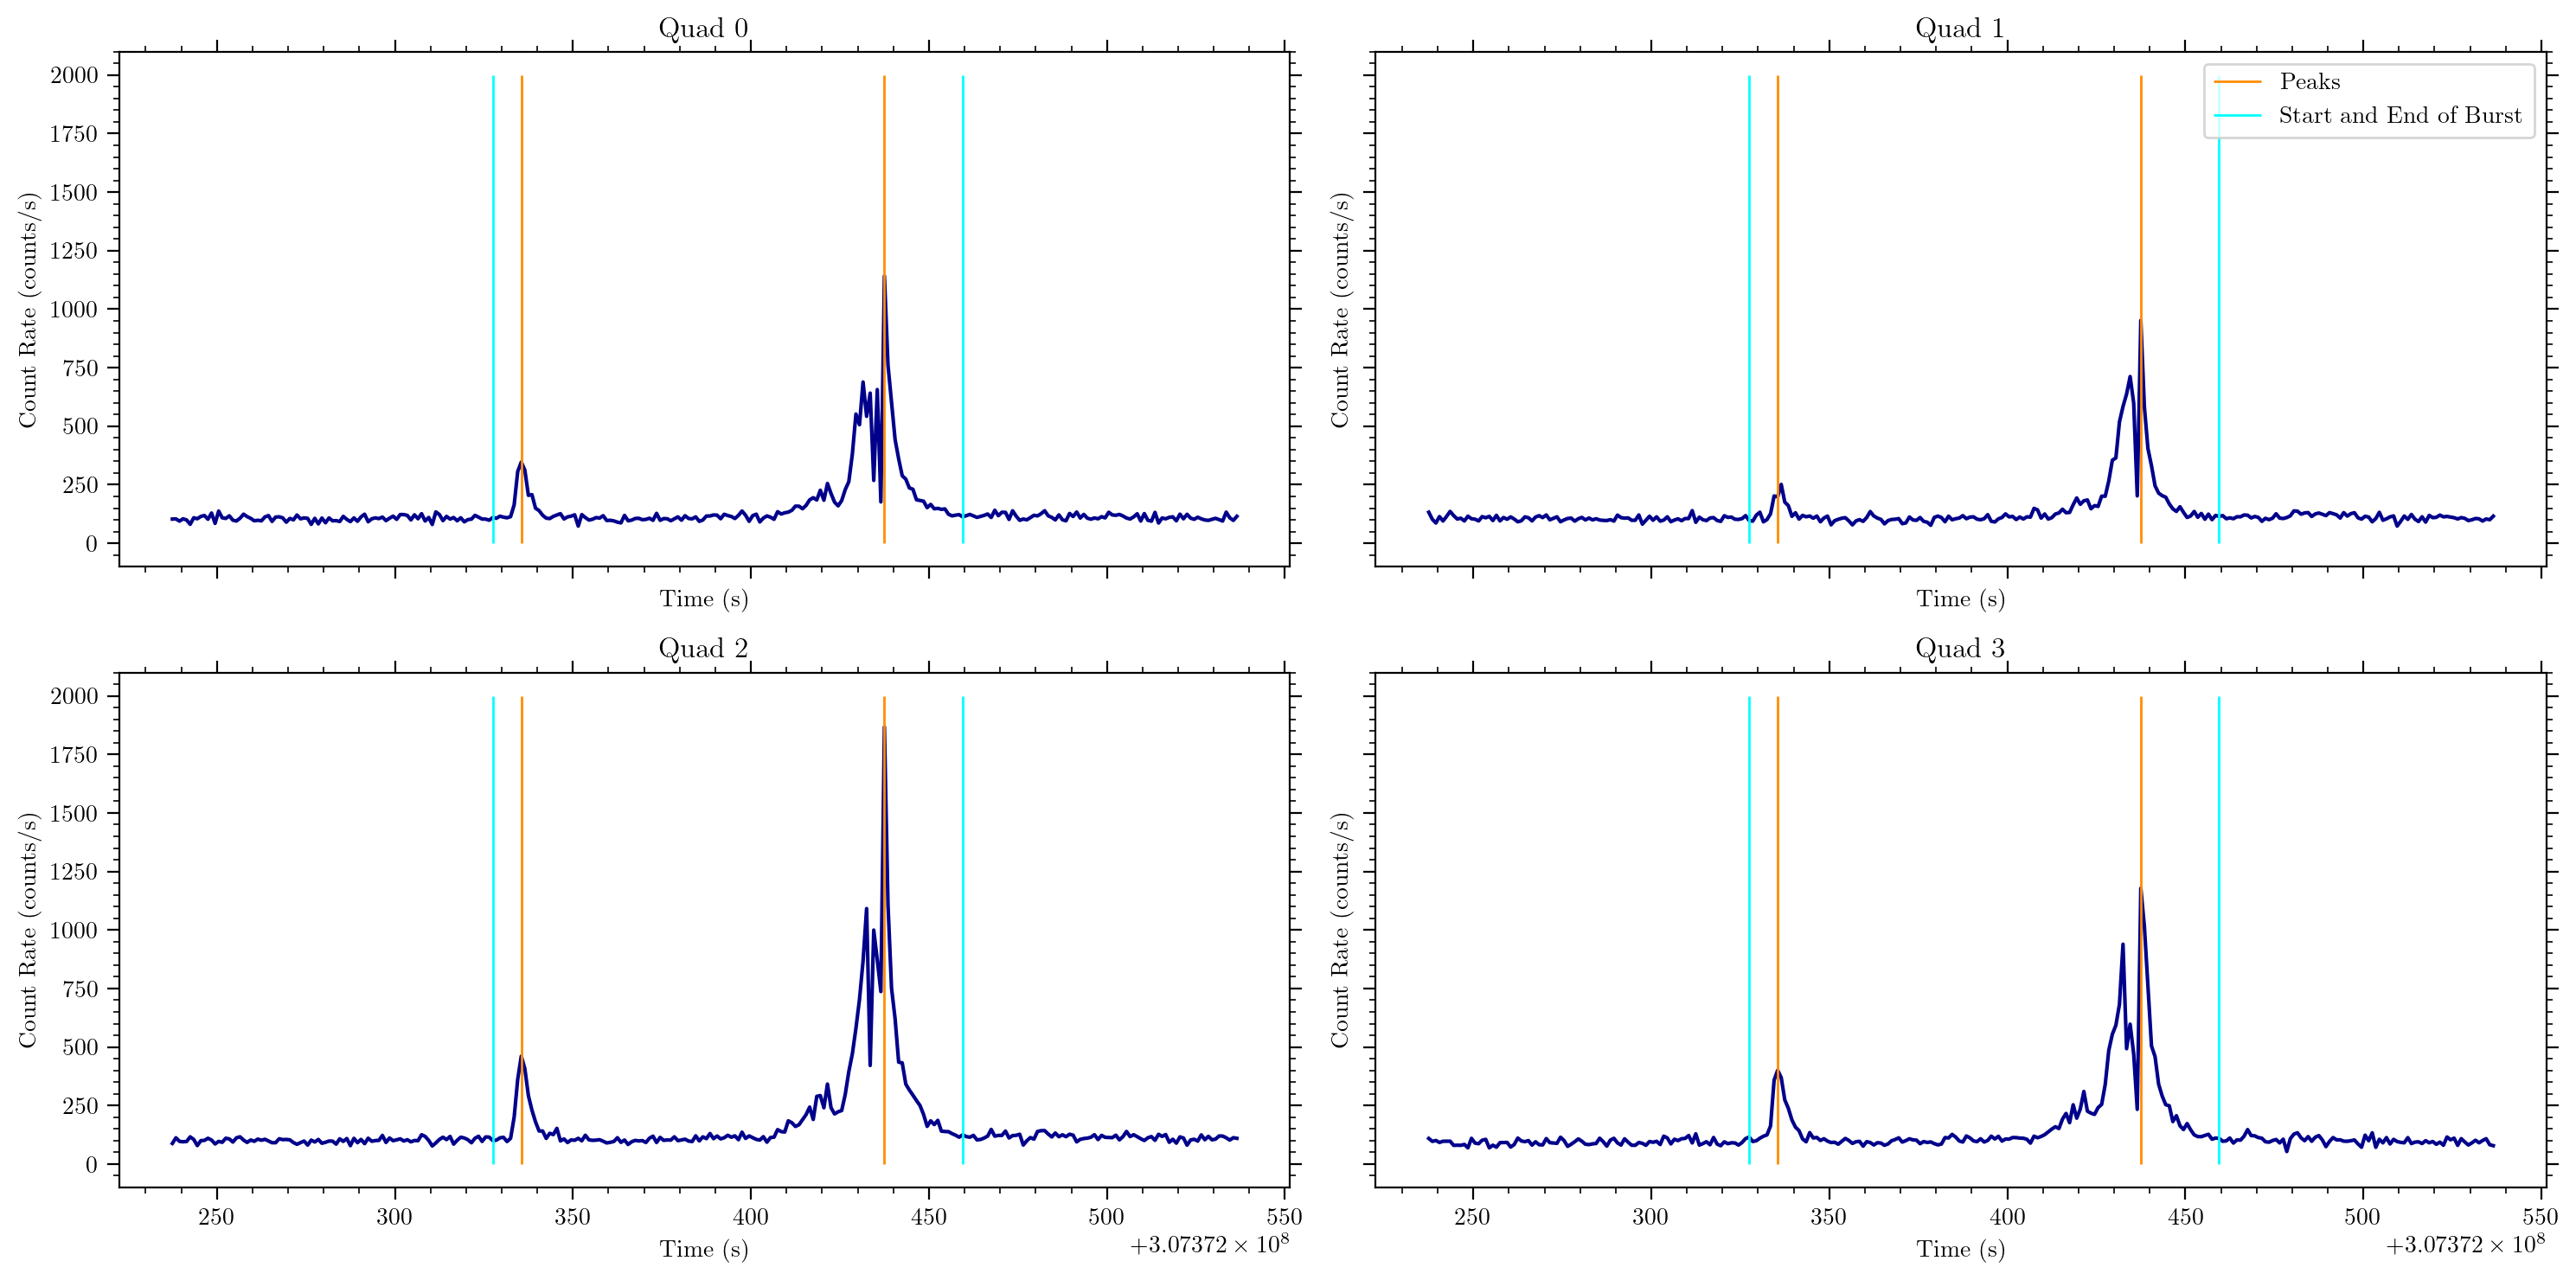

In [67]:
max = int(np.where(lc1_data['RATE'] == np.max(lc1_data['RATE']))[0])
start = max-110
end = max+22
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(15, 7.5), dpi=200)

ax[0,0].plot(lc1_data['TIME'][max-200:max+100], lc1_data['RATE'][max-200:max+100], color='darkblue')
ax[0,0].vlines(x = [lc1_data['TIME'][max], lc1_data['TIME'][max-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
ax[0,0].vlines(x = [lc1_data['TIME'][end], lc1_data['TIME'][start]], ymin=0, ymax=2000, color = 'cyan', label = 'Start and End of Burst', linewidth=1)
ax[0,0].set_title('Quad 0')
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Count Rate (counts/s)')

ax[0,1].plot(lc2_data['TIME'][max-200:max+100], lc2_data['RATE'][max-200:max+100], color='darkblue')
ax[0,1].vlines(x = [lc2_data['TIME'][max], lc2_data['TIME'][max-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
ax[0,1].vlines(x = [lc2_data['TIME'][end], lc2_data['TIME'][start]], ymin=0, ymax=2000, color = 'cyan', label = 'Start and End of Burst', linewidth=1)
ax[0,1].set_title('Quad 1')
ax[0,1].set_xlabel('Time (s)')
ax[0,1].set_ylabel('Count Rate (counts/s)')
ax[0,1].legend()

ax[1,0].plot(lc3_data['TIME'][max-200:max+100], lc3_data['RATE'][max-200:max+100], color='darkblue')
ax[1,0].vlines(x = [lc3_data['TIME'][max], lc3_data['TIME'][max-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
ax[1,0].vlines(x = [lc3_data['TIME'][end], lc3_data['TIME'][start]], ymin=0, ymax=2000, color = 'cyan', label = 'Start and End of Burst', linewidth=1)
ax[1,0].set_title('Quad 2')
ax[1,0].set_xlabel('Time (s)')
ax[1,0].set_ylabel('Count Rate (counts/s)')

ax[1,1].plot(lc4_data['TIME'][max-200:max+100], lc4_data['RATE'][max-200:max+100], color='darkblue')
ax[1,1].vlines(x = [lc4_data['TIME'][max], lc4_data['TIME'][max-102]],ymin=0, ymax=2000, color = 'darkorange', label = 'Peaks', linewidth=1)
ax[1,1].vlines(x = [lc4_data['TIME'][end], lc4_data['TIME'][start]], ymin=0, ymax=2000, color = 'cyan', label = 'Start and End of Burst', linewidth=1)
ax[1,1].set_title('Quad 3')
ax[1,1].set_xlabel('Time (s)')
ax[1,1].set_ylabel('Count Rate (counts/s)')

fig.tight_layout()
fig.show()

In [68]:
#time of grb
duration = lc4_data['TIME'][end] - lc4_data['TIME'][start]
print("The duration of the GRB is " + str(duration) + " seconds")

The duration of the GRB is 132.0 seconds


**Filtering and detrending the data**

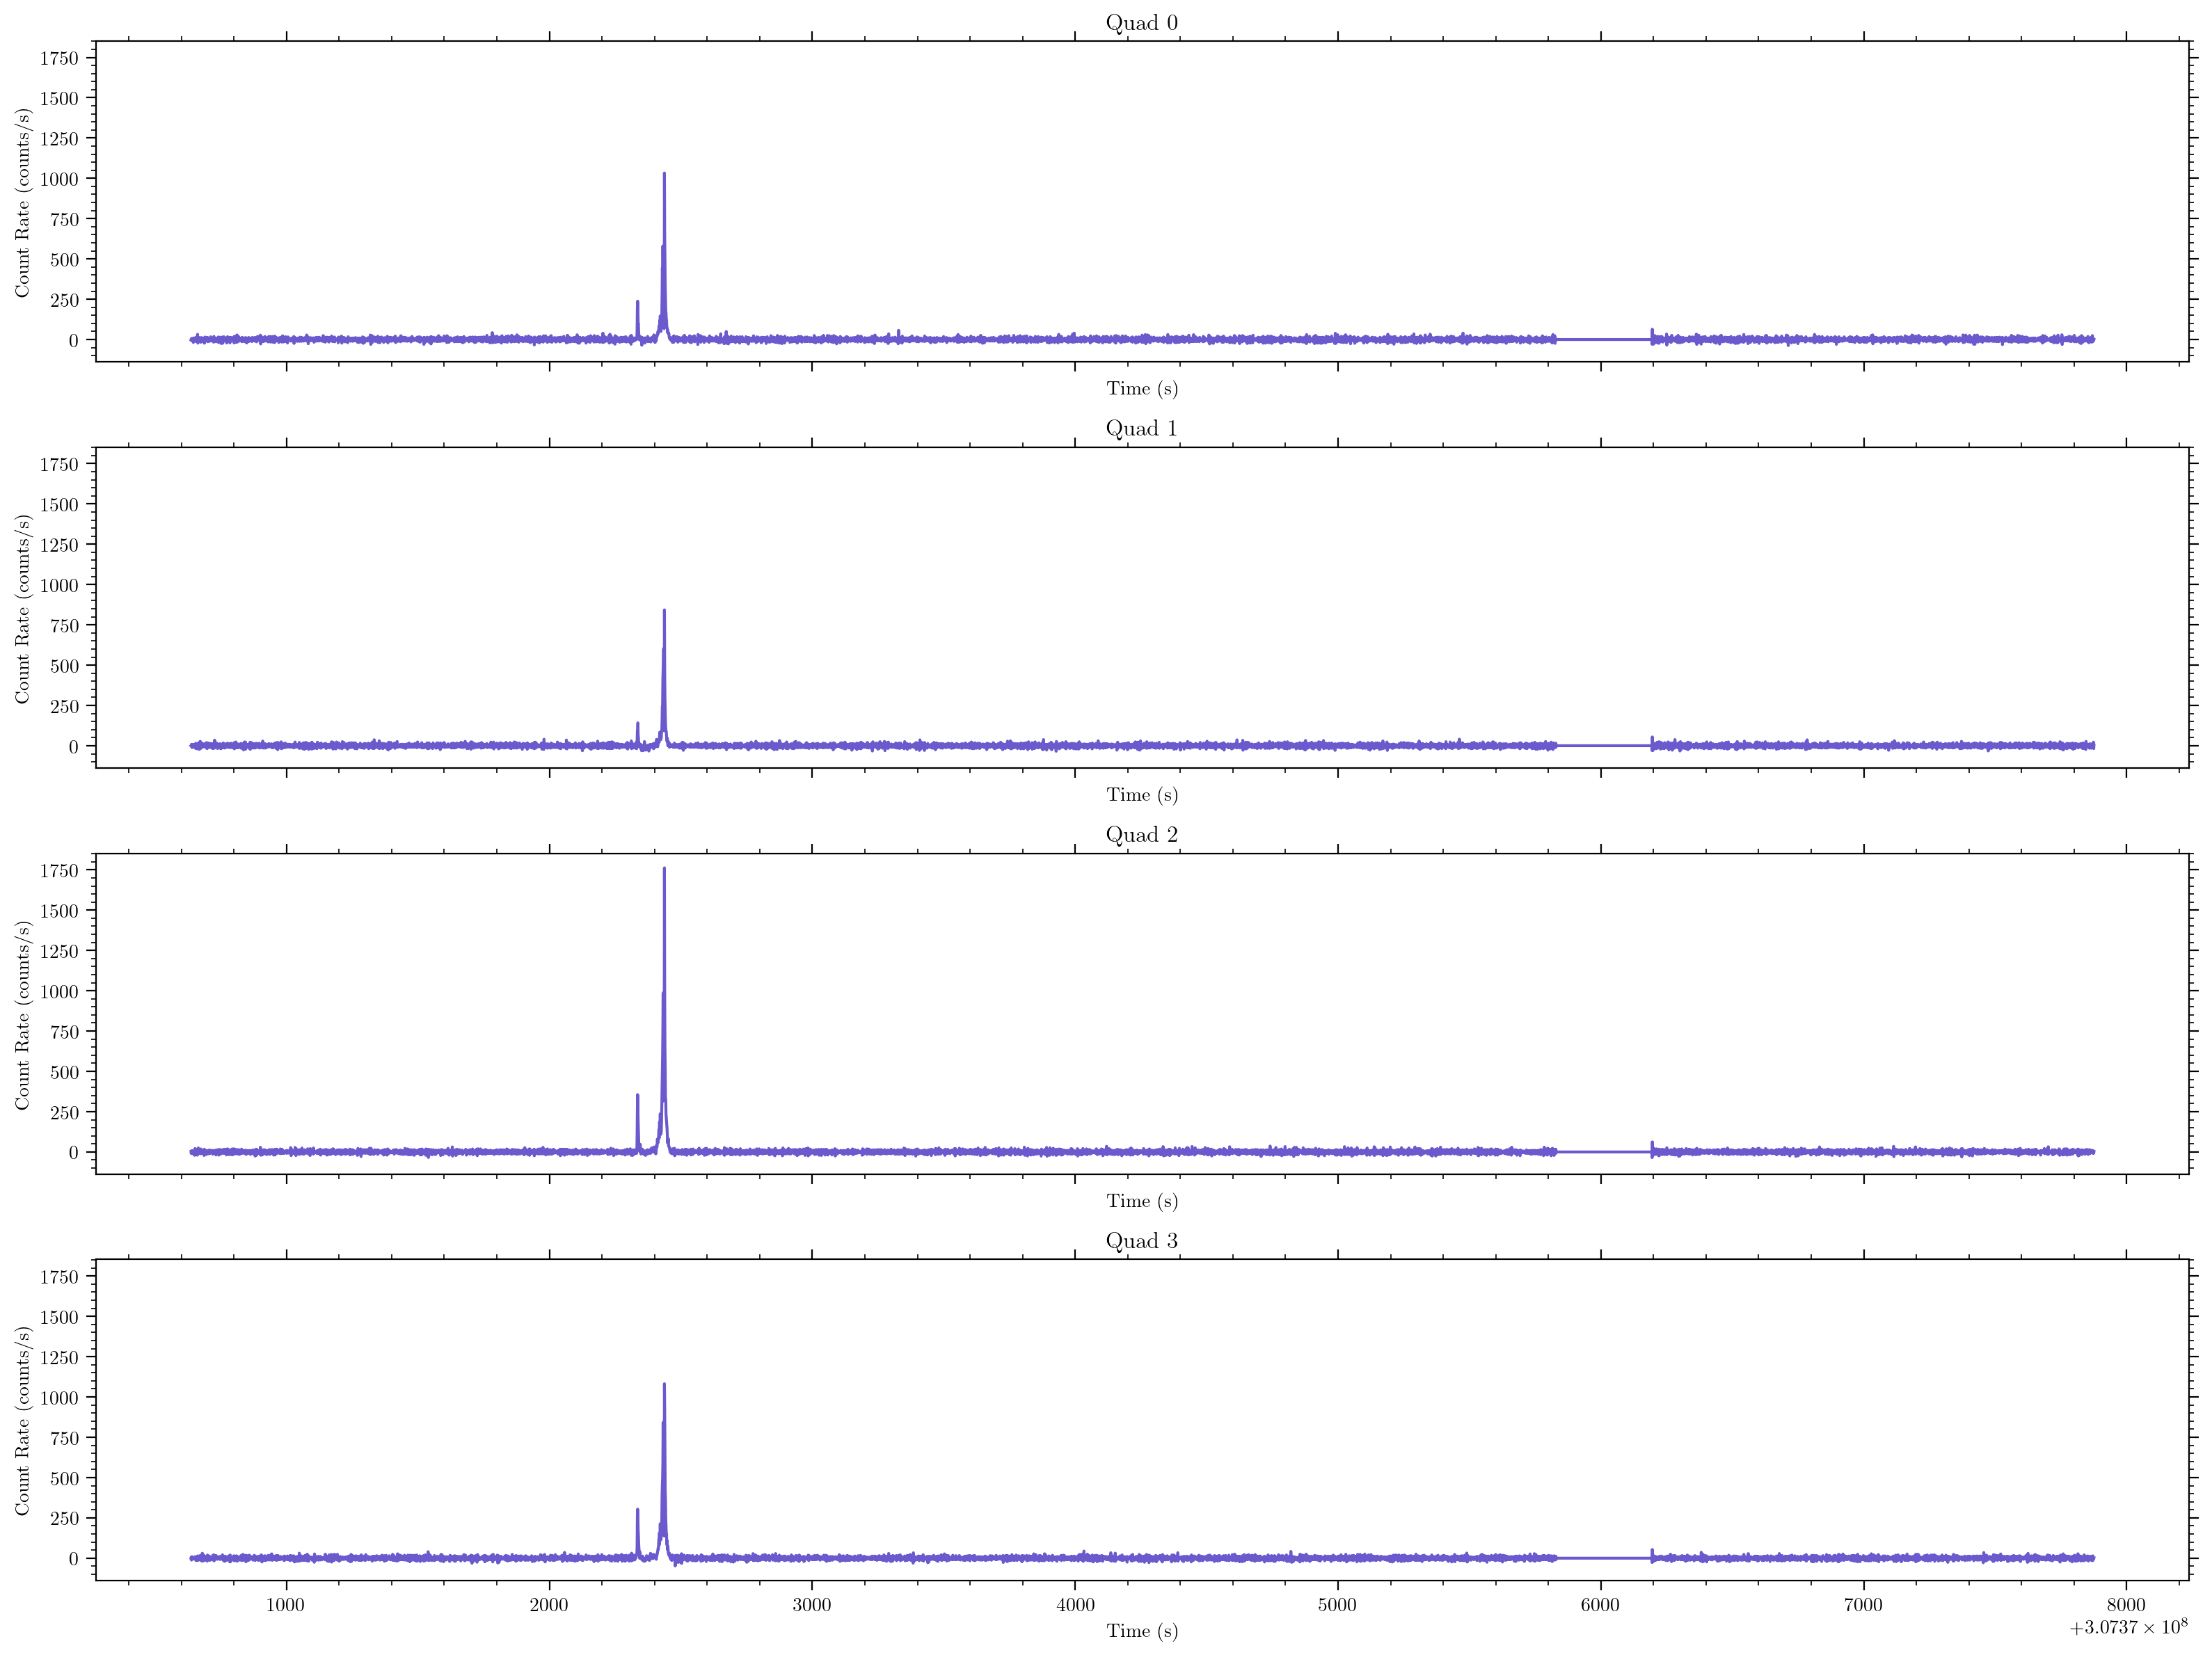

In [69]:
lc1_filtered, *_ = filter_and_detrend(lc1, start, end, 3)
lc2_filtered, *_ = filter_and_detrend(lc2, start, end, 3)
lc3_filtered, *_ = filter_and_detrend(lc3, start, end, 3)
lc4_filtered, *_ = filter_and_detrend(lc4, start, end, 3)

fig, ax = plt.subplots(4,1, sharex=True, sharey=True, figsize=(16,12), dpi=200)

ax[0].plot(lc1_filtered['TIME'], lc1_filtered['RATE'], color='slateblue')
ax[0].set_title('Quad 0')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Count Rate (counts/s)')


ax[1].plot(lc2_filtered['TIME'], lc2_filtered['RATE'], color='slateblue')
ax[1].set_title('Quad 1')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Count Rate (counts/s)')

ax[2].plot(lc3_filtered['TIME'], lc3_filtered['RATE'], color='slateblue')
ax[2].set_title('Quad 2')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Count Rate (counts/s)')

ax[3].plot(lc4_filtered['TIME'], lc4_filtered['RATE'], color='slateblue')
ax[3].set_title('Quad 3')
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('Count Rate (counts/s)')

fig.tight_layout()
fig.show()

**Estimating the noise and calculating SNR**

Method 1 - using RMS value of noise and peak value of signal
The SNR of the GRB in Quad 0 is 103.39603
The SNR of the GRB in Quad 1 is 86.30459
The SNR of the GRB in Quad 2 is 192.1228
The SNR of the GRB in Quad 3 is 113.22427


Method 2 - using mean of absolute value of noise and peak value of signal
The SNR of the GRB in Quad 0 is 129.74522
The SNR of the GRB in Quad 1 is 108.50125
The SNR of the GRB in Quad 2 is 241.41379
The SNR of the GRB in Quad 3 is 143.15683


Method 3 - adding the counts in the peak and noise regions 
The SNR of the GRB in Quad 0 is 9.15310625697684
The SNR of the GRB in Quad 1 is 6.505427593323349
The SNR of the GRB in Quad 2 is 15.802887315041668
The SNR of the GRB in Quad 3 is 12.929820452615022


Method 4 - modelling the noise as a gaussian 


The SNR of the GRB in Quad 0 is 35.787100827323826
The SNR of the GRB in Quad 1 is 28.932267124324643
The SNR of the GRB in Quad 2 is 62.41123840512198
The SNR of the GRB in Quad 3 is 39.43568921528827

 



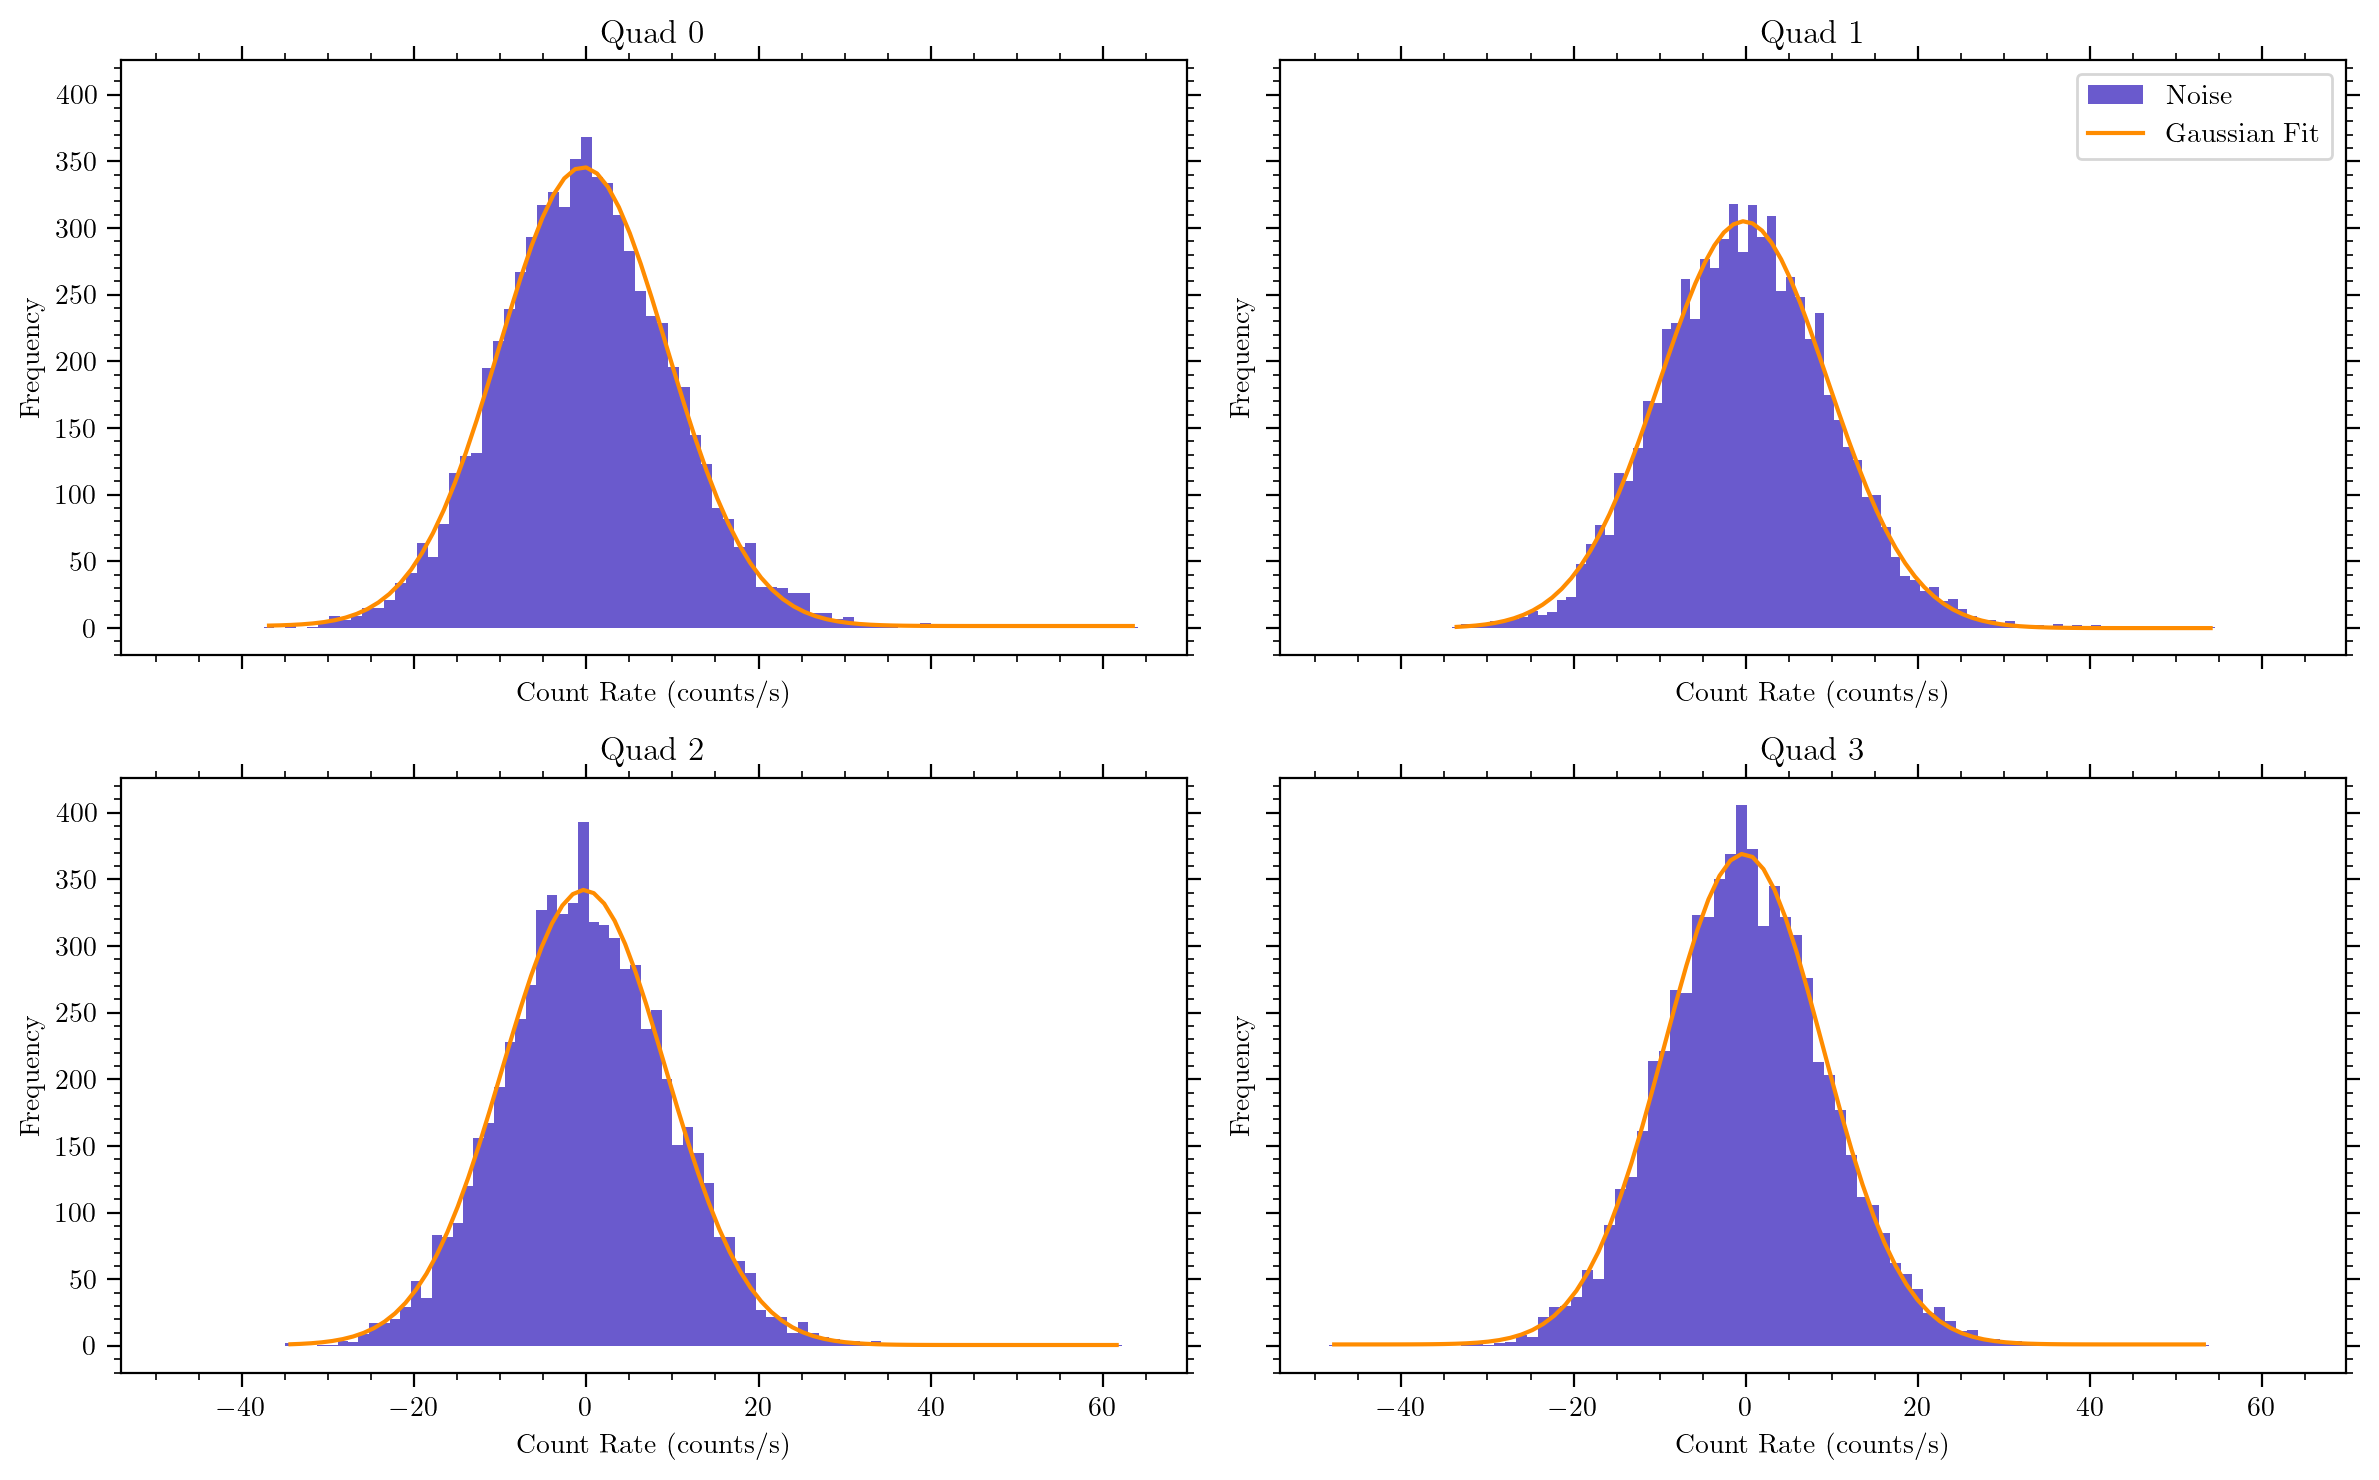

In [95]:
#method 1 - using RMS value of noise and peak value of signal
print("Method 1 - using RMS value of noise and peak value of signal")
print("The SNR of the GRB in Quad 0 is " + str(snr_rms(lc1, start, end)))
print("The SNR of the GRB in Quad 1 is " + str(snr_rms(lc2, start, end)))
print("The SNR of the GRB in Quad 2 is " + str(snr_rms(lc3, start, end)))
print("The SNR of the GRB in Quad 3 is " + str(snr_rms(lc4, start, end)))
print("\n")

#method 2 - using mean of absolute value of noise and peak value of signal
print("Method 2 - using mean of absolute value of noise and peak value of signal")
print("The SNR of the GRB in Quad 0 is " + str(snr_abs(lc1, start, end)))
print("The SNR of the GRB in Quad 1 is " + str(snr_abs(lc2, start, end)))
print("The SNR of the GRB in Quad 2 is " + str(snr_abs(lc3, start, end)))
print("The SNR of the GRB in Quad 3 is " + str(snr_abs(lc4, start, end)))
print("\n")

#method 3 - adding the counts in the peak and noise regions
print("Method 3 - adding the counts in the peak and noise regions ")

print("The SNR of the GRB in Quad 0 is " + str(snr_counts(lc1, start, end)))
print("The SNR of the GRB in Quad 1 is " + str(snr_counts(lc2, start, end)))
print("The SNR of the GRB in Quad 2 is " + str(snr_counts(lc3, start, end)))
print("The SNR of the GRB in Quad 3 is " + str(snr_counts(lc4, start, end)))
print("\n")

#method 4 - #modelling the noise as a gaussian
print("Method 4 - modelling the noise as a gaussian ")

lc = [lc1, lc2, lc3, lc4]
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12, 7.5), dpi=200)

for i in range(4):
    noise = snr_gauss(lc[i], start, end)[1]
    bins = snr_gauss(lc[i], start, end)[2]
    popt = snr_gauss(lc[i], start, end)[3]
    ax[i//2, i%2].hist(noise, bins=80, color='slateblue', label='Noise')
    ax[i//2, i%2].plot(bins, gaussian(bins, *popt), color='darkorange', label='Gaussian Fit')
    ax[i//2, i%2].set_title('Quad ' + str(i))
    ax[i//2, i%2].set_xlabel('Count Rate (counts/s)')
    ax[i//2, i%2].set_ylabel('Frequency')
    if i//2 == 0 and i%2 == 1: ax[i//2, i%2].legend()

fig.tight_layout()
fig.show()


print("The SNR of the GRB in Quad 0 is " + str(snr_gauss(lc1, start, end)[0]))
print("The SNR of the GRB in Quad 1 is " + str(snr_gauss(lc2, start, end)[0]))
print("The SNR of the GRB in Quad 2 is " + str(snr_gauss(lc3, start, end)[0]))
print("The SNR of the GRB in Quad 3 is " + str(snr_gauss(lc4, start, end)[0]))
print("\n \n")
